- given a set of stocks and assets, get the ideal portfolio, how much % of each for max return and min loss
- uses the sharpe ratio = portfolio return-risk free rate/st dev



In [ ]:
import yfinance as yf
import pandas as pd
from datetime import datetime,timedelta
import numpy as np
from scipy.optimize import minimize

In [ ]:
#define the list of tickers

tickers=['SPY','BND','GLD','QQQ','VTI']


In [ ]:
end_date= datetime.today()

In [ ]:
start_date= end_date - timedelta(days=5*365)
print(start_date)

2018-12-05 05:00:54.864144


In [ ]:
#Download adjusted closed prices
adj_close_df=pd.DataFrame()
for ticker in tickers:
  data=yf.download(ticker,start=start_date,end=end_date)
  adj_close_df[ticker]=data['Adj Close']

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [ ]:
print(adj_close_df)

                   SPY        BND         GLD         QQQ         VTI
Date                                                                 
2018-12-06  248.234039  68.952103  117.139999  161.431442  127.113922
2018-12-07  242.466125  69.092789  118.089996  156.101700  124.114548
2018-12-10  242.926102  69.163177  117.680000  157.736435  124.252609
2018-12-11  242.981277  69.171959  117.540001  158.258789  124.224976
2018-12-12  244.204773  69.101578  117.790001  159.651672  124.933403
...                ...        ...         ...         ...         ...
2023-11-27  454.480011  70.790237  186.770004  389.170013  225.089996
2023-11-28  454.929993  71.089394  189.259995  390.190002  225.229996
2023-11-29  454.609985  71.458359  189.539993  389.809998  225.330002
2023-11-30  456.399994  71.229004  188.750000  388.829987  226.259995
2023-12-01  459.100006  71.809998  192.009995  389.940002  228.169998

[1256 rows x 5 columns]


In [ ]:
#Calculate Lognormal Returns
log_returns=np.log(adj_close_df/adj_close_df.shift(1))

In [ ]:
#drop any missing log values
log_returns=log_returns.dropna()

- calcualte covariance matrix, this is used to measure total risk, each asset has a covariance and corelation with each other

In [ ]:
#do multiply by 252 to annulize returns
cov_matrix=log_returns.cov()*252
print(cov_matrix)

          SPY       BND       GLD       QQQ       VTI
SPY  0.045505  0.002587  0.003140  0.051392  0.046525
BND  0.002587  0.004521  0.003751  0.003205  0.002746
GLD  0.003140  0.003751  0.022168  0.004418  0.003302
QQQ  0.051392  0.003205  0.004418  0.066668  0.052497
VTI  0.046525  0.002746  0.003302  0.052497  0.047943


In [ ]:
from re import S
#calcuate portfolio performance metrics

# 1. portfolio risk by portfolio Std

def standard_deviation(weights,cov_matrix):
  variance=weights.T @ cov_matrix @ weights
  return np.sqrt(variance)

# 2. expected return -- based on historical returns

def expected_return (weights,log_returns):
  return np.sum(log_returns.mean()*weights)*252


In [ ]:
#calcualte the sharp ratio

def sharpe_ratio (weights,log_returns,cov_matrix,risk_free_rate):
  return(expected_return (weights,log_returns)-risk_free_rate)/standard_deviation(weights,cov_matrix)

In [ ]:
pip install fredapi

In [ ]:
#set the risk free rate
from fredapi import Fred
# easy way the risk free rate is 2% -- this is what is in the finance textbooks
#use the federal reserve api, fred api https://fred.stlouisfed.org/docs/api/api_key.html

fred=Fred(api_key='57b3e5a6eab0ce7cec8584d4cb4e26d0')
ten_year_treasury_rate=fred.get_series_latest_release('GS10')/100
risk_free_rate=ten_year_treasury_rate.iloc[-1]
print(risk_free_rate)

0.045


In [ ]:
#define function to minimze (negative Sharpe Ratio)
#using the
def neg_sharpe_ratio(weights,log_returns,cov_matrix,risk_free_rate):
  return -sharpe_ratio (weights,log_returns,cov_matrix,risk_free_rate)

In [ ]:
#set the constraints and bounds
#sum of all portfolio weights must equal 1
constraints={'type':'eq','fun':lambda weights:np.sum(weights)-1}

#lower and upper bound for each weights, 0 for lower means you cant short any of the assets, 0.5 for higher means that any one of these stocks cant be more than 50% of the portfolio
bounds=[(0,0.5) for _ in range(len(tickers))]


In [ ]:
#set the initial weights -- each one is just equally weighted

initial_weights = np.array([1/len(tickers)]*len(tickers))
initial_weights

array([0.2, 0.2, 0.2, 0.2, 0.2])

In [ ]:
#get the optimal weights to maximize sharp ratio
#scipi doesnt have a maximize function, so if you do the smallest negative sharp ratio its same as maximize
optimized_results=minimize(neg_sharpe_ratio, initial_weights,args=(log_returns,cov_matrix,risk_free_rate),method='SLSQP',constraints=constraints,bounds=bounds)

In [ ]:
#get optimal weights

optimal_weights=optimized_results.x

In [ ]:
#display the analytics of the portfolio

print("Optimal Weights:")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: {weight:.4f}")

optimal_portfolio_return = expected_return(optimal_weights, log_returns)
optimal_portfolio_volatility = standard_deviation(optimal_weights, cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimal_weights, log_returns, cov_matrix, risk_free_rate)

print(f"Expected Annual Return: {optimal_portfolio_return:.4f}")
print(f"Expected Volatility: {optimal_portfolio_volatility:.4f}")
print(f"Sharpe Ratio: {optimal_sharpe_ratio:.4f}")

Optimal Weights:
SPY: 0.0000
BND: 0.0000
GLD: 0.5000
QQQ: 0.5000
VTI: 0.0000
Expected Annual Return: 0.1382
Expected Volatility: 0.1563
Sharpe Ratio: 0.5962


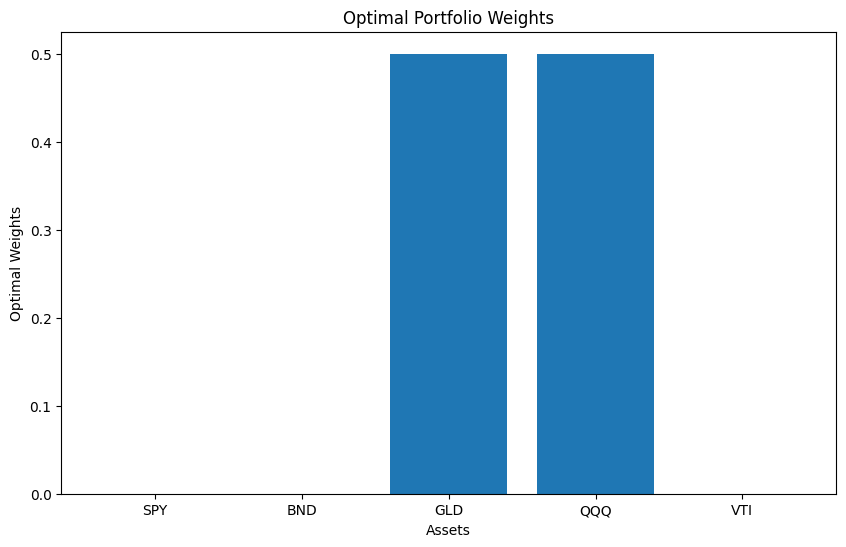

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(tickers, optimal_weights)

plt.xlabel('Assets')
plt.ylabel('Optimal Weights')
plt.title('Optimal Portfolio Weights')

plt.show()